In [41]:
# Name: Arooba Hanif
# Roll Number: Ezi-ML-B1-227
# Shift Time: Remote
# Internship Type: Hybird/Remote

# TASK 05

In [17]:
# Project 5: Hyperparameter Optimization (Titanic)
# Logistic Regression & Decision Tree with GridSearchCV + RandomizedSearchCV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix
)

from scipy.stats import loguniform, randint  # for randomized search distributions

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 200)


In [18]:
CSV_PATH = "Titanic-Dataset.csv"  # e.g., "Titanic-Dataset.csv"

df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head()


(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
print("Columns:", list(df.columns))
print("\nMissing values per column:\n", df.isna().sum())


Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Missing values per column:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [20]:
df = df.copy()

# Create FamilySize and IsAlone (simple strong features)
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

# Drop columns that won't help (high-cardinality / messy)
to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]
for c in to_drop:
    if c in df.columns:
        df.drop(columns=c, inplace=True, errors="ignore")

# Keep only columns we have
print("Remaining columns:", list(df.columns))


Remaining columns: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone']


In [21]:
# Target & features
y = df["Survived"].astype(int)
X = df.drop(columns=["Survived"])

# Identify categorical vs numeric columns (automatically)
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical:", cat_cols)
print("Numeric:", num_cols)

# Split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train.shape, X_test.shape


Categorical: ['Sex', 'Embarked']
Numeric: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone']


((712, 9), (179, 9))

In [22]:
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)


In [23]:
# Pipelines with shared preprocessing
pipe_lr = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000, solver="liblinear", random_state=42))
])

pipe_dt = Pipeline([
    ("preprocess", preprocess),
    ("clf", DecisionTreeClassifier(random_state=42))
])

# Train
pipe_lr.fit(X_train, y_train)
pipe_dt.fit(X_train, y_train)

# Predict
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:, 1]

y_pred_dt = pipe_dt.predict(X_test)
y_proba_dt = pipe_dt.predict_proba(X_test)[:, 1]

def summarize(y_true, y_pred, y_proba, label):
    return {
        "Model": label,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_proba)
    }

baseline_results = []
baseline_results.append(summarize(y_test, y_pred_lr, y_proba_lr, "LogReg (Default)"))
baseline_results.append(summarize(y_test, y_pred_dt, y_proba_dt, "DecisionTree (Default)"))

pd.DataFrame(baseline_results)


,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,LogReg (Default),0.804469,0.783333,0.681159,0.728682,0.850593
1,DecisionTree (Default),0.793296,0.750000,0.695652,0.721805,0.767984


In [24]:
# Logistic Regression param grids
grid_params_lr = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l1", "l2"],        # liblinear supports l1/l2
}

rand_params_lr = {
    "clf__C": loguniform(1e-3, 1e+2),
    "clf__penalty": ["l1", "l2"]
}

# Decision Tree param grids
grid_params_dt = {
    "clf__max_depth": [3, 5, 7, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__criterion": ["gini", "entropy"],
}

rand_params_dt = {
    "clf__max_depth": randint(2, 20),
    "clf__min_samples_split": randint(2, 20),
    "clf__min_samples_leaf": randint(1, 10),
    "clf__criterion": ["gini", "entropy"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [25]:
# Grid Search — Logistic Regression
grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=grid_params_lr,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=0
)
grid_lr.fit(X_train, y_train)

# Grid Search — Decision Tree
grid_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid=grid_params_dt,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=0
)
grid_dt.fit(X_train, y_train)

print("Best (Grid) LR params:", grid_lr.best_params_)
print("Best (Grid) DT params:", grid_dt.best_params_)


Best (Grid) LR params: {'clf__C': 1, 'clf__penalty': 'l2'}
Best (Grid) DT params: {'clf__criterion': 'gini', 'clf__max_depth': 7, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}


In [26]:
# Randomized Search — Logistic Regression
rand_lr = RandomizedSearchCV(
    estimator=pipe_lr,
    param_distributions=rand_params_lr,
    n_iter=20,
    scoring="f1",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rand_lr.fit(X_train, y_train)

# Randomized Search — Decision Tree
rand_dt = RandomizedSearchCV(
    estimator=pipe_dt,
    param_distributions=rand_params_dt,
    n_iter=30,
    scoring="f1",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rand_dt.fit(X_train, y_train)

print("Best (Random) LR params:", rand_lr.best_params_)
print("Best (Random) DT params:", rand_dt.best_params_)


Best (Random) LR params: {'clf__C': np.float64(0.37253938395788866), 'clf__penalty': 'l2'}
Best (Random) DT params: {'clf__criterion': 'gini', 'clf__max_depth': 16, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 8}


In [27]:
def eval_estimator(name, est, X_te, y_te):
    y_hat = est.predict(X_te)
    y_prob = est.predict_proba(X_te)[:, 1] if hasattr(est, "predict_proba") else None
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_te, y_hat),
        "Precision": precision_score(y_te, y_hat),
        "Recall": recall_score(y_te, y_hat),
        "F1-score": f1_score(y_te, y_hat),
        "ROC-AUC": roc_auc_score(y_te, y_prob) if y_prob is not None else np.nan
    }

results = []
# Defaults
results.append(eval_estimator("LogReg (Default)", pipe_lr, X_test, y_test))
results.append(eval_estimator("DecisionTree (Default)", pipe_dt, X_test, y_test))
# Grid best
results.append(eval_estimator("LogReg (Grid Best)", grid_lr.best_estimator_, X_test, y_test))
results.append(eval_estimator("DecisionTree (Grid Best)", grid_dt.best_estimator_, X_test, y_test))
# Random best
results.append(eval_estimator("LogReg (Random Best)", rand_lr.best_estimator_, X_test, y_test))
results.append(eval_estimator("DecisionTree (Random Best)", rand_dt.best_estimator_, X_test, y_test))

comparison_df = pd.DataFrame(results).sort_values(by="F1-score", ascending=False)
comparison_df.reset_index(drop=True)


,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,LogReg (Default),0.804469,0.783333,0.681159,0.728682,0.850593
1,LogReg (Grid Best),0.804469,0.783333,0.681159,0.728682,0.850593
2,LogReg (Random Best),0.804469,0.783333,0.681159,0.728682,0.850461
3,DecisionTree (Default),0.793296,0.750000,0.695652,0.721805,0.767984
4,DecisionTree (Random Best),0.776536,0.716418,0.695652,0.705882,0.795323
5,DecisionTree (Grid Best),0.776536,0.795918,0.565217,0.661017,0.772398


<Figure size 500x400 with 0 Axes>

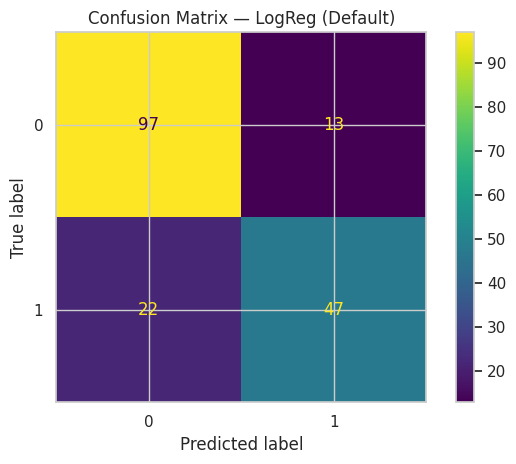

Saved: confusion_matrix_best.png


In [28]:
# Pick row with highest F1-score
best_row = comparison_df.loc[comparison_df["F1-score"].idxmax()]
best_name = best_row["Model"]

# Map name back to estimator
name_to_est = {
    "LogReg (Default)": pipe_lr,
    "DecisionTree (Default)": pipe_dt,
    "LogReg (Grid Best)": grid_lr.best_estimator_,
    "DecisionTree (Grid Best)": grid_dt.best_estimator_,
    "LogReg (Random Best)": rand_lr.best_estimator_,
    "DecisionTree (Random Best)": rand_dt.best_estimator_,
}
best_est = name_to_est[best_name]

# Confusion Matrix
plt.figure(figsize=(5,4))
ConfusionMatrixDisplay.from_estimator(best_est, X_test, y_test)
plt.title(f"Confusion Matrix — {best_name}")
plt.tight_layout()
plt.savefig("confusion_matrix_best.png", dpi=200)
plt.show()

print("Saved: confusion_matrix_best.png")


<Figure size 600x500 with 0 Axes>

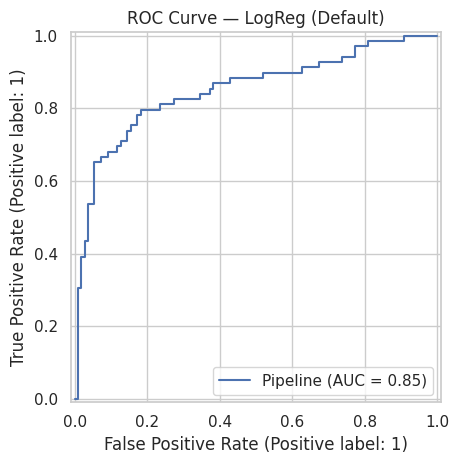

Saved: roc_curve_best.png


In [29]:
plt.figure(figsize=(6,5))
RocCurveDisplay.from_estimator(best_est, X_test, y_test)
plt.title(f"ROC Curve — {best_name}")
plt.tight_layout()
plt.savefig("roc_curve_best.png", dpi=200)
plt.show()

print("Saved: roc_curve_best.png")


In [30]:
print("==== Best Params Summary ====")
print("LR Grid:", grid_lr.best_params_)
print("DT Grid:", grid_dt.best_params_)
print("LR Random:", rand_lr.best_params_)
print("DT Random:", rand_dt.best_params_)


==== Best Params Summary ====
LR Grid: {'clf__C': 1, 'clf__penalty': 'l2'}
DT Grid: {'clf__criterion': 'gini', 'clf__max_depth': 7, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}
LR Random: {'clf__C': np.float64(0.37253938395788866), 'clf__penalty': 'l2'}
DT Random: {'clf__criterion': 'gini', 'clf__max_depth': 16, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 8}


In [31]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


In [32]:
# Hyperparameter grid for Logistic Regression
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100],   # Regularization strength
    "clf__penalty": ["l2"],              # L1 not supported with saga solver here
    "clf__solver": ["lbfgs", "liblinear"]
}

# Hyperparameter distributions for Randomized Search
param_dist = {
    "clf__C": np.logspace(-3, 3, 100),   # Random from 0.001 to 1000
    "clf__solver": ["lbfgs", "liblinear"],
    "clf__penalty": ["l2"]
}


In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define numeric and categorical columns
numeric_features = ["Age", "Fare"]
categorical_features = ["Sex", "Pclass", "Embarked"]

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Final pipeline
pipe_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

# Hyperparameter grid
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "liblinear"]
}

# Grid Search
grid_search = GridSearchCV(
    pipe_lr,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters (Grid Search):", grid_search.best_params_)
print("Best CV Accuracy (Grid Search):", grid_search.best_score_)

# Predictions on Test Set
y_pred_grid = grid_search.best_estimator_.predict(X_test)


Best Parameters (Grid Search): {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV Accuracy (Grid Search): 0.7992317541613316


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Predictions already done
y_pred_grid = grid_search.best_estimator_.predict(X_test)

# Metrics
print("Test Accuracy:", accuracy_score(y_test, y_pred_grid))
print("Precision:", precision_score(y_test, y_pred_grid))
print("Recall:", recall_score(y_test, y_pred_grid))
print("F1 Score:", f1_score(y_test, y_pred_grid))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_grid))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_grid)
print("\nConfusion Matrix:\n", cm)


Test Accuracy: 0.7877094972067039
Precision: 0.7540983606557377
Recall: 0.6666666666666666
F1 Score: 0.7076923076923077

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       110
           1       0.75      0.67      0.71        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.78       179


Confusion Matrix:
 [[95 15]
 [23 46]]


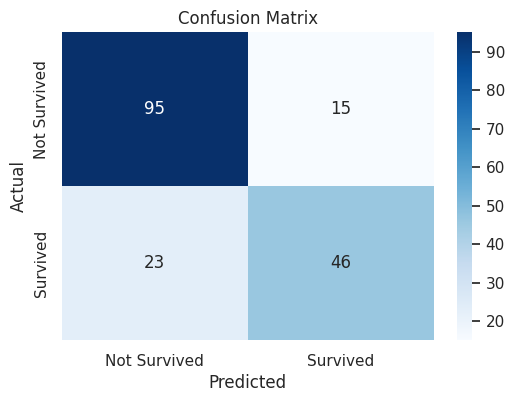

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_grid)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Survived","Survived"], yticklabels=["Not Survived","Survived"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


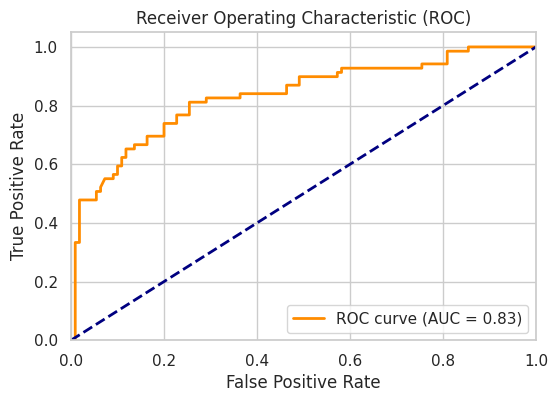

In [39]:
from sklearn.metrics import roc_curve, auc

# Probabilities for ROC
y_pred_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()


In [40]:
from sklearn.metrics import classification_report

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_grid))


Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       110
           1       0.75      0.67      0.71        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.78       179

